# Adopted User Prediction

This notebook serves as a report for take-home challenge exercise under SpringBoard Data Science Career Track curriculum. 

## Load Environment

In [501]:
%load_ext autoreload
%autoreload 2

from udf import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import pickle
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#%load_ext pycodestyle_magic

%load_ext watermark
%watermark -a "by Zhao Bing" -d -t -v -p numpy,pandas,sklearn,xgboost,matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
by Zhao Bing 2019-05-12 21:54:45 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.2
pandas 0.24.1
sklearn 0.20.1
xgboost 0.81
matplotlib 3.0.2


## Data Inputs

In [289]:
# Due to error loading takehome_user.csv file, need to detect the encoding
import chardet
with open(path_user, 'rb') as f:
    result = chardet.detect(f.read()) 
result['encoding']

'ISO-8859-1'

In [290]:
path_user = "./takehome_users.csv"
path_user_engagement = "./takehome_user_engagement.csv"
user_df = pd.read_csv(path_user,encoding=result['encoding'])
user_engagement_df = pd.read_csv(path_user_engagement)

In [291]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [292]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Data Type Checking and Conversion

In [293]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [294]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


#### Convert DateTime

In [295]:
# convert creation_time to datetime format
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'],format='%Y-%m-%d %H:%M:%S')
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'],format='%Y-%m-%d %H:%M:%S')

#### Create DateTime Features

In [296]:
print("The dataset covers from {} to {}.".format(user_df['creation_time'].min(),user_df['creation_time'].max()))

The dataset covers from 2012-05-31 00:43:27 to 2014-05-30 23:59:19.


As this dataset covers two years period, the datetime column will be converted into the following parts: 
* Month number: 'creation_Month'
* Week-of-the-day: 'creation_timeDayofweek'
* Time elapsed since creation: 'creation_timeElapsed'

Besides, 'creation_timeElapsed' and 'last_session_creation_time' can be utilized to calculate
* days since the last session: 'days_since_last_session'
* days from creation to last session: 'days_create_to_last'

In [297]:
# convert datetime to Month, Dayofweek, and Elapsed time (unit=seconds) 
func_add_datepart(user_df, 'creation_time', attr = ['Month', 'Dayofweek'])

# calculate days since last session, referrencing to the latest 'last_session_creation_time'
last_session_max = user_df['last_session_creation_time'].max()
user_df['days_since_last_session'] = (last_session_max - user_df['last_session_creation_time'])/86400.0

# calculate the number of days between last_session and creation_time
user_df['days_create_to_last'] = (user_df['last_session_creation_time'] - user_df['creation_timeElapsed'])/86400.0

In [298]:
user_df.head()

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_timeMonth,creation_timeDayofweek,creation_timeElapsed,days_since_last_session,days_create_to_last
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,4,1,1398138810,45.462037,0.0
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,11,4,1384487104,67.467894,136.0
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,1,1363734892,443.655532,0.0
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,5,1,1369123768,380.284282,1.0
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,3,1358417660,500.197569,5.0


#### Extract Email Domain

In [299]:
user_df['email_domain'] = user_df['email'].apply(lambda x: re.search("@[\w.]+", x).group())

#### Explicitly Define String Columns

In [300]:
col_tmp = ['org_id']
user_df[col_tmp] = user_df[col_tmp].astype('object')

#### Number of Invitation
Rather than keeping the feature `invited_by_user_id`, it might be more useful to count the number of referrals by each user_id. Royal users might have the tendency to invite more users. 

In [301]:
# count the number of users being invited by each user_id
number_of_invites = user_df['invited_by_user_id'].value_counts()
number_of_invites.name = 'number_of_invites'
user_df = user_df.merge(number_of_invites, how='left', left_on='object_id', right_index=True)
user_df['number_of_invites'].fillna(value=0, inplace=True)

#### Labeling of "Adopted User" 

According to definition provided: an "adopted user" is a user who has logged into the product on three separate days in at least one seven-day period. The "takehome_user_engagement.csv" dataset will be utilized to generate such label. 

In [302]:
# calculate the total number of days the user has logged on per week
user_engagement_sum_per_week = user_engagement_df.groupby("user_id").resample('W',on='time_stamp').apply('sum')
# definition of 'adopted_user'
label_adopted_user = 1*(user_engagement_sum_per_week['visited'].groupby(level=0).max() >= 3)
# rename the label as 'adopted_user'
label_adopted_user.name = 'adopted_user'
# merge the label to main dataframe: user_df
user_df = user_df.merge(label_adopted_user, how='inner', left_on='object_id', right_index=True)
# fill adopted_user = NA with 0, i.e. those without engagement record is consider not an 'adopted user'

In [303]:
print("{:.0f} of {} or {:.1f}% are labeled as adpoter users".format(user_df['adopted_user'].sum(), 
                                                                user_df.shape[0],
                                                                user_df['adopted_user'].sum() / user_df.shape[0] * 100))

1445 of 8823 or 16.4% are labeled as adpoter users


In [304]:
user_df.head()

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_timeMonth,creation_timeDayofweek,creation_timeElapsed,days_since_last_session,days_create_to_last,email_domain,number_of_invites,adopted_user
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,4,1,1398138810,45.462037,0.0,@yahoo.com,0.0,0
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,11,4,1384487104,67.467894,136.0,@gustr.com,0.0,1
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,1,1363734892,443.655532,0.0,@gustr.com,1.0,0
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,5,1,1369123768,380.284282,1.0,@yahoo.com,0.0,0
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,3,1358417660,500.197569,5.0,@yahoo.com,0.0,0


#### Dealing with Columns with High Cardinality

* `name` and `email`: can be considered identify information, thus will be removed during model training.
* `org_id` and `email_domain` requires further assessment by calculate the frequency and response rates. 

In [305]:
user_df[['name', 'email', 'creation_source', 'org_id', 'email_domain']].nunique()

name               8453
email              8810
creation_source       5
org_id              417
email_domain        812
dtype: int64

`org_id`: there are no dominant levels, thus consider to drop this feature. 

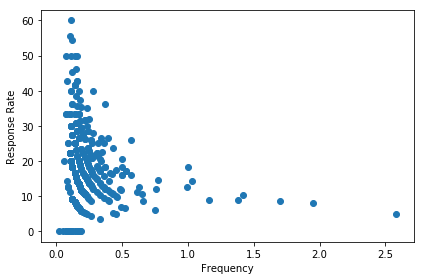

adopted_user,0,1,Count,Frequency,Response_Rate,Frequency_Cumu
org_id,,,,,,
0,217,11,228,2.58,4.82,2.58
1,158,14,172,1.95,8.14,4.53
2,137,13,150,1.70,8.67,6.23
3,112,13,125,1.42,10.40,7.65
4,111,11,122,1.38,9.02,9.03
6,93,9,102,1.16,8.82,10.19
9,78,13,91,1.03,14.29,11.22
7,72,16,88,1.00,18.18,12.22
5,76,11,87,0.99,12.64,13.21


In [242]:
# Examine the frequency and response rate of each category of a single feature
df_ct = func_cat_crosstab(user_df['org_id'], user_df['adopted_user'], sortby='Frequency')
display(df_ct)

`email_domain`: top six domains contains 90% of data, thus the rest domains are named as others. It appears that @hotmail.com has more than average 'adopted users', which @yahoo.com has relatively fewer. 

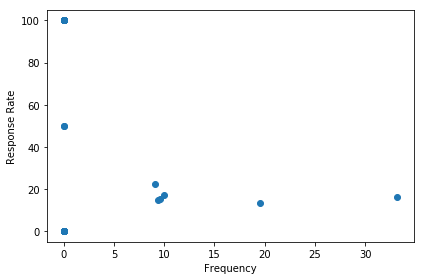

adopted_user,0,1,Count,Frequency,Response_Rate,Frequency_Cumu
email_domain,,,,,,
@gmail.com,2451,479,2930,33.21,16.35,33.21
@yahoo.com,1492,234,1726,19.56,13.56,52.77
@jourrapide.com,732,151,883,10.01,17.10,62.78
@gustr.com,712,130,842,9.54,15.44,72.32
@cuvox.de,706,122,828,9.38,14.73,81.70
@hotmail.com,622,181,803,9.10,22.54,90.80
@mumdc.com,1,1,2,0.02,50.00,90.82
@xvnbr.com,2,0,2,0.02,0.00,90.84
@luque.com,1,1,2,0.02,50.00,90.86


In [243]:
# Examine the frequency and response rate of each category of a single feature
df_ct = func_cat_crosstab(user_df['email_domain'], user_df['adopted_user'], sortby='Frequency')
display(df_ct)

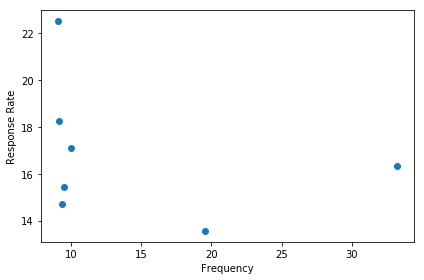

adopted_user,0,1,Count,Frequency,Response_Rate,Frequency_Cumu
email_domain,,,,,,
@gmail.com,2451,479,2930,33.21,16.35,33.21
@yahoo.com,1492,234,1726,19.56,13.56,52.77
@jourrapide.com,732,151,883,10.01,17.10,62.78
@gustr.com,712,130,842,9.54,15.44,72.32
@cuvox.de,706,122,828,9.38,14.73,81.70
@others.com,663,148,811,9.19,18.25,90.89
@hotmail.com,622,181,803,9.10,22.54,99.99


In [306]:
major_email_domains = ['@gmail.com','@yahoo.com','@jourrapide.com','@gustr.com','@cuvox.de','@hotmail.com']
user_df.loc[~user_df['email_domain'].isin(major_email_domains),'email_domain'] = '@others.com'
df_ct = func_cat_crosstab(user_df['email_domain'], user_df['adopted_user'], sortby='Frequency')
display(df_ct)

#### Select Columns for Further Preprocessing 
Remove columns such as, 
* Identity features: `object_id`, `name`, `email`, `org_id`, `invited_by_user_id`
* Datetime features: `last_session_creation_time` is replaced with `days_since_last_session` and `days_create_to_last`

In [308]:
col_selected = ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip',
                'creation_timeMonth', 'creation_timeDayofweek','days_since_last_session','days_create_to_last',
                'email_domain','number_of_invites','adopted_user']
user_df = user_df[col_selected]

In [345]:
# update data type to categorical 
col_cat = ['creation_timeMonth', 'creation_timeDayofweek']
user_df[col_cat] = user_df[col_cat].astype('object')

In [311]:
# with open('./user_df.pickle', 'wb') as handle:
#     pickle.dump(user_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('./user_df.pickle', 'rb') as handle:
#     user_df = pickle.load(handle)

### Collect Data Types for Features

This information will be used later to during pre-processing for different data types. 

In [346]:
cols_dict, cols_df = func_df_col_names_by_type(user_df.drop(columns=['adopted_user']), flag_print = False)

In [347]:
cols_dict

{'cols_number': ['opted_in_to_mailing_list',
  'enabled_for_marketing_drip',
  'days_since_last_session',
  'days_create_to_last',
  'number_of_invites'],
 'cols_string': ['creation_source',
  'creation_timeMonth',
  'creation_timeDayofweek',
  'email_domain'],
 'cols_binary': ['opted_in_to_mailing_list', 'enabled_for_marketing_drip'],
 'cols_number_exclude_binary': ['days_since_last_session',
  'days_create_to_last',
  'number_of_invites'],
 'cols_string_include_binary': ['creation_source',
  'creation_timeMonth',
  'creation_timeDayofweek',
  'email_domain',
  'opted_in_to_mailing_list',
  'enabled_for_marketing_drip'],
 'cols_datetime': [],
 'cols_timedelta': [],
 'cols_category': [],
 'cols_others': []}

## Exploratory Data Analysis

In this part, the following exploratory data analysis is done: 
* explore the basic stats including, mean, min, max, quantils, and percentage of missing values for each column 
* use Box Plots for identifying any potential outliers (numerical features only)
* plot the disitributions factored by label ('adopted_user')
* perform simply correlation analysis and visualization to examine the correlation among features and label. 

### Summarize of Statistics

It is observed that 
* There are no missing values. 
* All data are within reasonable ranges.

In [316]:
# summarize: statistics | missing value | data type | sample data
user_df_stat = pd.concat([pd.DataFrame(user_df.dtypes,columns=['type']), func_df_describe_all(user_df)], axis=1)
#df_raw_stat.to_excel('../reports/EDA-data-summary.xlsx', sheet_name='statistics', index=True)
func_df_display_all(user_df_stat)

,type,count,unique,top,freq,mean,std,min,25%,50%,75%,max,miss_perc
creation_source,object,8823,5,ORG_INVITE,3188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
opted_in_to_mailing_list,int64,8823,NaN,NaN,NaN,0.252295,0.434354,0,0,0,1,1,0.0
enabled_for_marketing_drip,int64,8823,NaN,NaN,NaN,0.151989,0.359031,0,0,0,0,1,0.0
creation_timeMonth,int64,8823,NaN,NaN,NaN,6.23983,3.43377,1,3,6,9,12,0.0
creation_timeDayofweek,int64,8823,NaN,NaN,NaN,2.99207,1.98291,0,1,3,5,6,0.0
days_since_last_session,float64,8823,NaN,NaN,NaN,263.743,226.055,0,41.9459,221.971,449.905,736.277,0.0
days_create_to_last,float64,8823,NaN,NaN,NaN,59.2221,144.172,0,0,1,20,729,0.0
email_domain,object,8823,7,@gmail.com,2930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
number_of_invites,float64,8823,NaN,NaN,NaN,0.535419,1.36256,0,0,0,0,12,0.0
adopted_user,int32,8823,NaN,NaN,NaN,0.163776,0.370094,0,0,0,0,1,0.0


### Box Plots (Check Outliers for Numerical Features)

From the box plots below, it can be observed that: 
* Most users' last session is around 220 days before the latest date in the data;
* Most users became inactive right after creating their accounts;
* Most users do not invite other users;

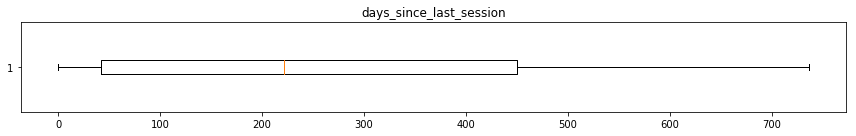

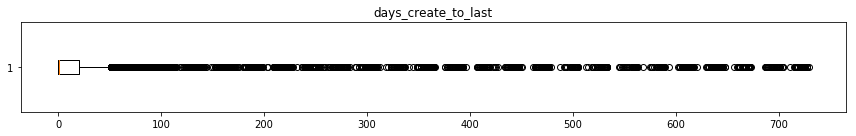

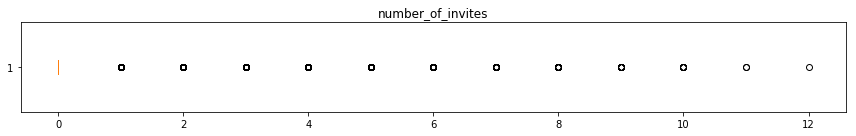

In [350]:
for c in cols_dict['cols_number_exclude_binary']:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(user_df[c], vert=False)
    plt.title(c)
    plt.tight_layout()
    plt.show()

### Visualization of Distributions


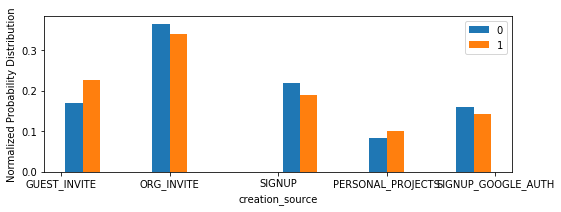

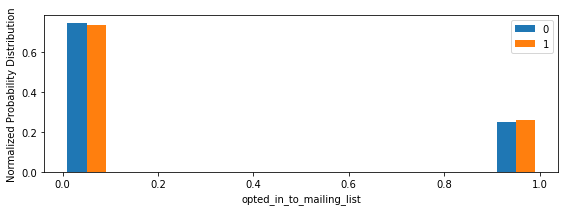

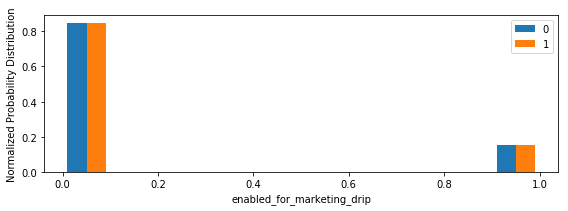

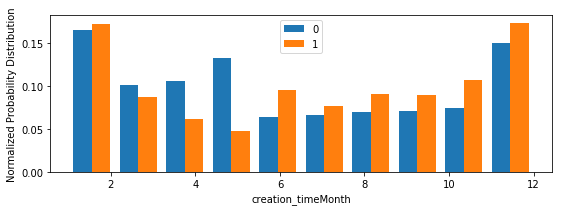

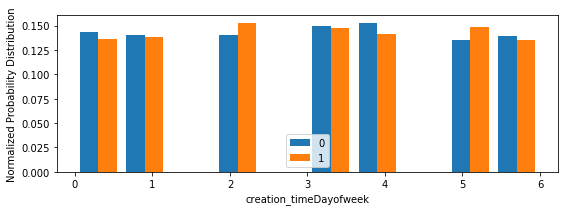

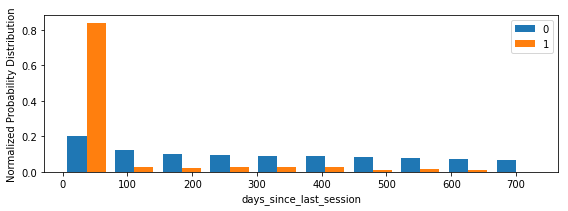

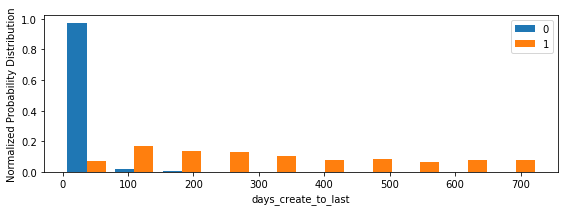

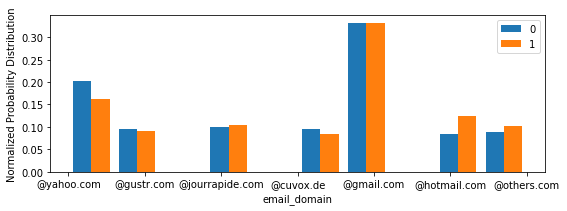

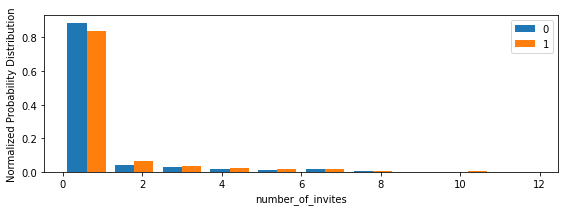

In [333]:
func_eda_hist_by_label_plot(user_df.drop(columns=['adopted_user']), user_df['adopted_user'], figsize=(8,3))

### Correlations Analysis

#### Pearson Correlation (Numerical Features Only)

In [329]:
# pearson correlation 
user_df.corr()['adopted_user'].sort_values(ascending=False)

adopted_user                  1.000000
days_create_to_last           0.815360
creation_timeMonth            0.058553
number_of_invites             0.052447
opted_in_to_mailing_list      0.009473
enabled_for_marketing_drip    0.003733
creation_timeDayofweek        0.002852
days_since_last_session      -0.403210
Name: adopted_user, dtype: float64

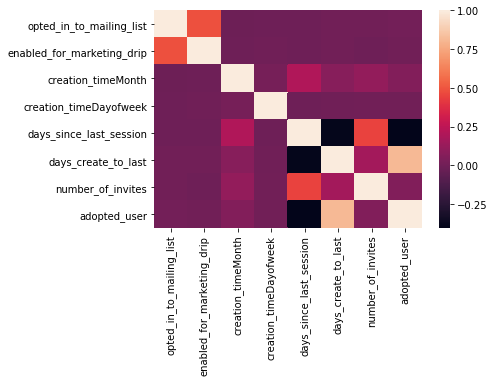

In [334]:
sns.heatmap(user_df.corr())

#### Pair Plots (Numerical Features Only)

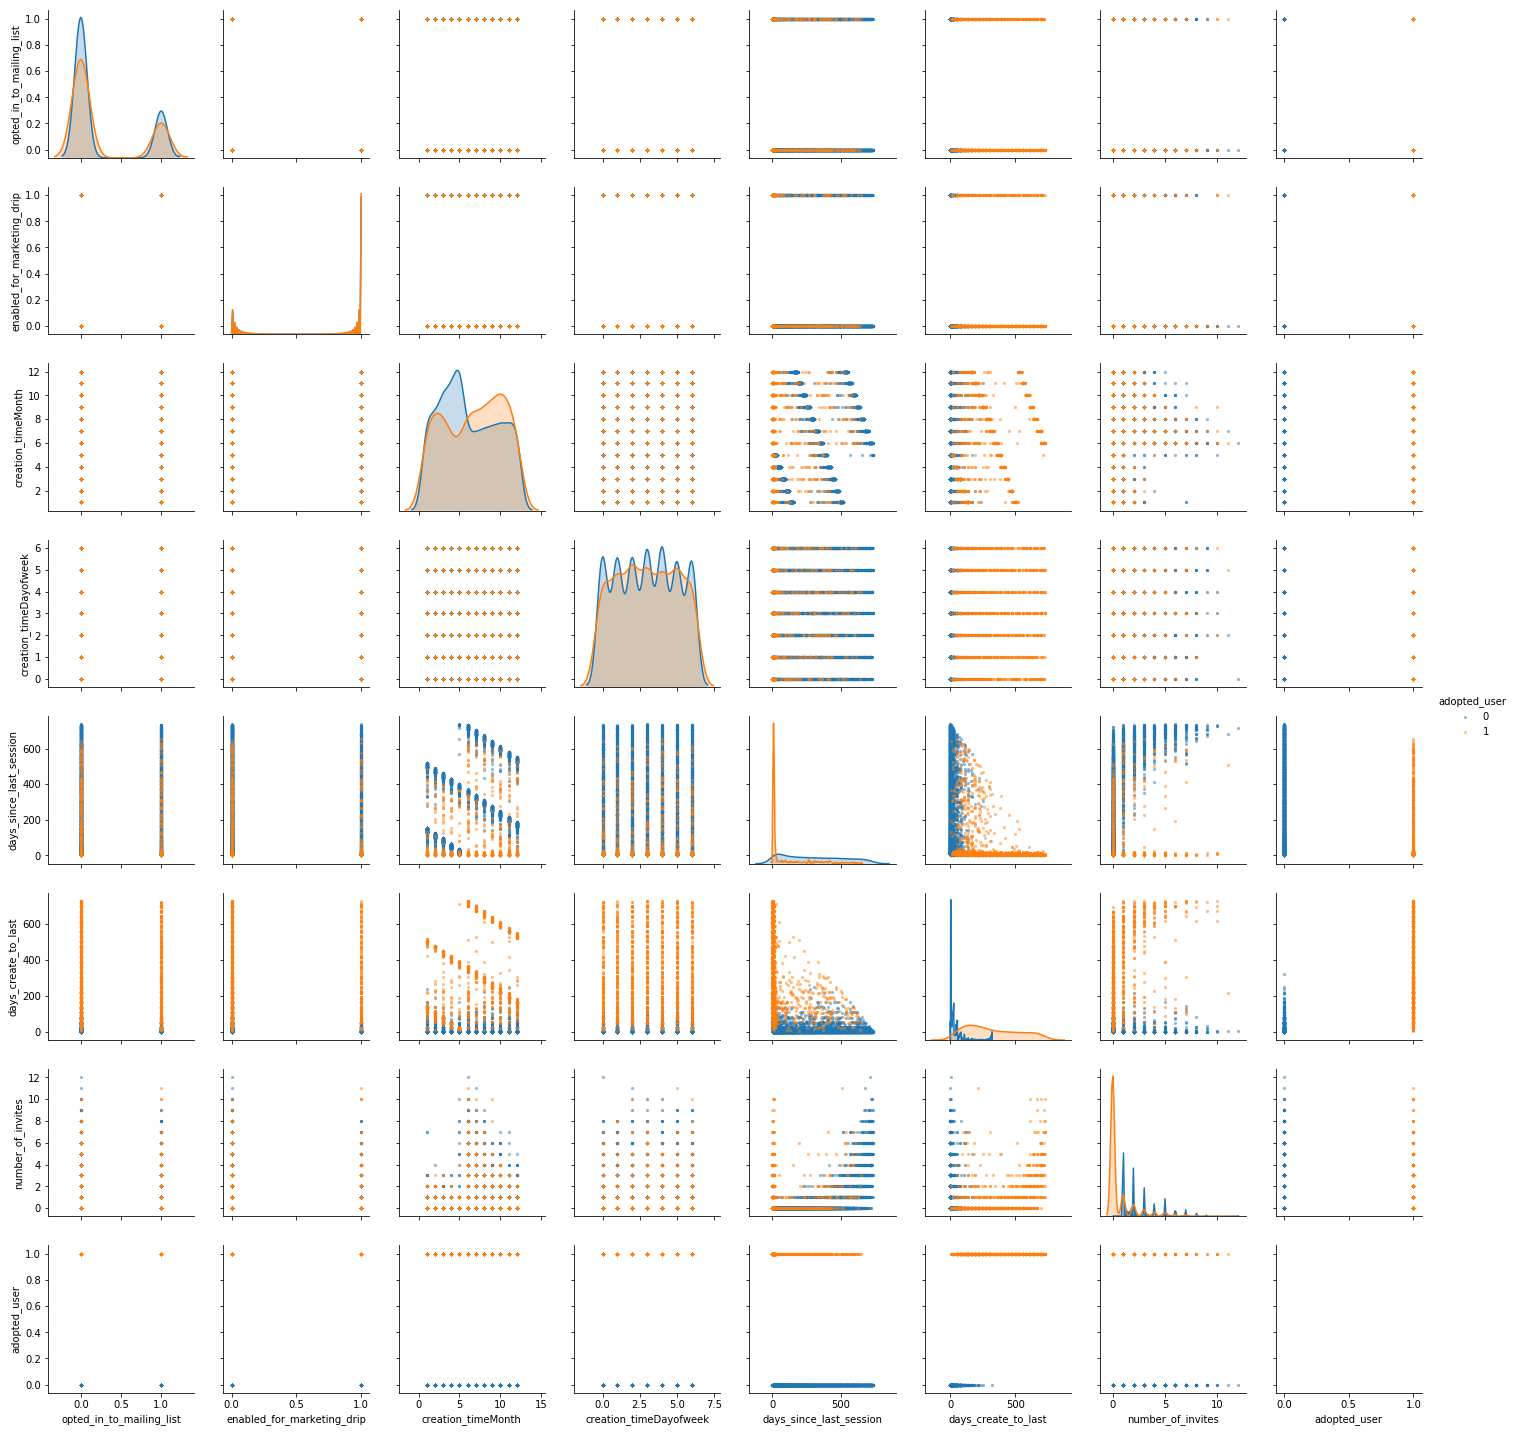

In [326]:
g = sns.pairplot(user_df, hue="adopted_user",plot_kws=dict(linewidth=0, alpha=0.5, s=10))

#### Cramers' V Test (For Categorical Features) 

For categorical and binary features, it is found that the `creation_timeMonth`, `ceation_source` and `email_domain` have relatively higher correlation with the label `adopted_user`. 

Note: Cramer’s V test measures the association betwwen two nominal features. It is an enhancement of the Chi-Square test (which provides result on whether it is a significant relationship between variables, without quantifying how significant and important it is). Cramer’s V varies between 0 and 1. Close to 0 it shows little association between variables. Close to 1, it indicates a strong association.

In [348]:
# features that are categorical
func_df_cramers_v(user_df[cols_dict['cols_string_include_binary']],user_df['adopted_user'])

,feature,cramers_v
1,creation_timeMonth,0.043242
0,creation_source,0.018442
3,email_domain,0.018005
2,creation_timeDayofweek,0.000000
4,opted_in_to_mailing_list,0.000000
5,enabled_for_marketing_drip,0.000000


### Discussion

#### Discussion on Correlation Analysis

From the correlation results and distribution plots above, it shows that following fields are more important including:
* `creation_timeMonth`: more adopted users during later half of the year. 
* `days_since_last_session`: more adopted users if it is shorter (i.e., users are recently active)
* `days_create_to_last`: more adopted users if it is longer (i.e., users have longer engagement period since creation)
* `number_of_invites`: more adopted users with larger number of invites. 

## Model

### Train-Test Split

The dataset if imbalanced with 16.4% 'adopted_user'. Thus stratified train-test-split is implemented. 

In [394]:
# stratified split 70-30%
label_name = 'adopted_user'
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(user_df.drop(label_name,axis=1), user_df[label_name],
                                                                test_size = 0.30, random_state = 42, 
                                                                stratify=user_df[label_name])

print('Training dataframe shape:', df_X_train.shape)
print('Test dataframe Shape:', df_X_test.shape)
print('Label = 1 in training set = {:.2f}%'.format((df_y_train.sum()/df_y_train.shape[0]*100.0)))
print('Label = 0 in test set = {:.2f}%'.format((df_y_test.sum()/df_y_test.shape[0]*100.0)))


Training dataframe shape: (6176, 9)
Test dataframe Shape: (2647, 9)
Label = 1 in training set = 16.37%
Label = 0 in test set = 16.40%


### Pre-Processing 

#### Training Data

In [395]:
# scaling of numerical features
col_num = ['days_since_last_session', 'days_create_to_last', 'number_of_invites']
scaler_standard = StandardScaler()
df_X_train[col_num] = scaler_standard.fit_transform(df_X_train[col_num])
# one-hot encoding for categorical features
col_cat = ['creation_source', 'creation_timeMonth', 'creation_timeDayofweek', 'email_domain']
df_X_train = pd.get_dummies(df_X_train,columns=col_cat,drop_first=True,dtype=float)
# record columns in final training data
col_train = df_X_train.columns.values

In [396]:
df_X_train.shape

(6176, 32)

#### Test Data

In [397]:
# scaling of numerical features
df_X_test[col_num] = scaler_standard.transform(df_X_test[col_num])

# One-hot encoding, and align column names
df_X_test = pd.get_dummies(df_X_test,columns=col_cat,drop_first=True,dtype=float)
col_test = df_X_test.columns.values

# Get missing columns in the training test
missing_cols = set( col_train ) - set( col_test)
# Add a missing column in test set with default value equal to 0 (i.e., indicating this level does not exists)
for c in missing_cols:
    df_X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_X_test = df_X_test[col_train]

df_X_test.shape

(2647, 32)

#### Upsampling

Due to the imbalanced dataset, it might be worth to try upsampling. 

In [398]:
from imblearn.over_sampling import SMOTE
X_upsampled, y_upsampled = SMOTE().fit_resample(df_X_train, df_y_train)

In [448]:
print('Training dataframe shape:', X_upsampled.shape)
print('Test dataframe Shape:', y_upsampled.shape)
print('Label = 1 in upsampled training set = {:.2f}%'.format((y_upsampled.sum()/y_upsampled.shape[0]*100.0)))

Training dataframe shape: (10330, 32)
Test dataframe Shape: (10330,)
Label = 1 in upsampled training set = 50.00%


### Model Selection using Cross-Validation

Several machine learning classifiers are compared with their default hyper-parameters. For decision tree based models (e.g. GradientBoosting, RandomForest and XGBoost), 100 trees/estimators are adopted for a fair comparison. 

#### Original Imbalanced Dataset

In [468]:
models_fitted =[]  # record models
models_fitted_names = []  # record model names 

# define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [GaussianNB(),
          LogisticRegression(random_state=42, verbose=0, n_jobs=-1, solver='lbfgs'), 
          RandomForestClassifier(n_estimators=100, random_state=42, verbose=0, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=0),
          XGBClassifier(n_estimators=100, random_state=42, verbose=0, n_jobs=-1)
         ]
names = ["NaiveBayes","Logistic","RandomForest","GradientBoosting","XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    
    # original dataset
    score = cross_validate(model, df_X_train.values, df_y_train.values, scoring=scoring,
                           cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    models_fitted.append(model.fit(df_X_train.values, df_y_train.values))
    models_fitted_names.append(name)
    
    # upsampled dataset
    score = cross_validate(model, X_upsampled, y_upsampled, scoring=scoring,
                           cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name+'_upsampled')
    df_scores = pd.concat([df_scores, df_score])
    models_fitted.append(model.fit(X_upsampled, y_upsampled))
    models_fitted_names.append(name+'_upsampled')


Executing NaiveBayes model.
Executing Logistic model.
Executing RandomForest model.
Executing GradientBoosting model.
Executing XGBoosting model.


In [465]:
df_scores[['Name','test_prec','test_rec','test_f1','test_roc_auc']].groupby('Name').agg(['mean','std'])

test_prec            test_rec             test_f1  \
                                mean       std      mean       std      mean   
Name                                                                           
GradientBoosting            0.919416  0.018961  0.899112  0.004347  0.909081   
GradientBoosting_upsampled  0.971624  0.003047  0.980833  0.005865  0.976197   
Logistic                    0.943746  0.024316  0.875374  0.013694  0.908236   
Logistic_upsampled          0.970372  0.006118  0.963020  0.009882  0.966657   
NaiveBayes                  0.892636  0.030814  0.932732  0.015535  0.912155   
NaiveBayes_upsampled        0.958478  0.008284  0.955663  0.005944  0.957060   
RandomForest                0.928193  0.026245  0.887236  0.007419  0.907103   
RandomForest_upsampled      0.976076  0.005965  0.986254  0.001862  0.981132   
XGBoosting                  0.925330  0.019269  0.891192  0.011129  0.907860   
XGBoosting_upsampled        0.971137  0.002791  0.983349  0.005231  0.977197   

                                     test_roc_auc            
                                 std         mean       std  
Name                                                         
GradientBoosting            0.010210     0.993880  0.001849  
GradientBoosting_upsampled  0.003174     0.997269  0.000491  
Logistic                    0.018030     0.989813  0.003334  
Logistic_upsampled          0.006137     0.995052  0.000931  
NaiveBayes                  0.022784     0.979779  0.007299  
NaiveBayes_upsampled        0.006422     0.984747  0.003094  
RandomForest                0.013672     0.989975  0.004952  
RandomForest_upsampled      0.003381     0.998276  0.000412  
XGBoosting                  0.012181     0.994103  0.002150  
XGBoosting_upsampled        0.002682     0.997553  0.000465

### Model Evaluation based on Fixed Validation Set

The summary of F1-score above suggests RandomForest might be the right candidate for final model. Although model trained with upsampled data is performs better in general in terms of F1-score, the usefulness of upsampling on model performance is further examined with a fixed validadtion set. 

In [469]:
df_scores_vali = pd.DataFrame()

for model, name in zip(models_fitted, models_fitted_names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}    
    y_pred_test = model.predict(df_X_test.values)
    #print("Test accuracy = {:.6f}".format(accuracy_score(df_y_test.values, y_pred_test)))
    unique_label = np.unique(df_y_test.values)
    cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)
    cr = classification_report(df_y_test.values, y_pred_test, output_dict=True)
    df_score = pd.DataFrame(cr)
    df_score.index = df_score.index.set_names(['metric'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores_vali = pd.concat([df_scores_vali, df_score])

Executing NaiveBayes model.
Executing NaiveBayes_upsampled model.
Executing Logistic model.
Executing Logistic_upsampled model.
Executing RandomForest model.
Executing RandomForest_upsampled model.
Executing GradientBoosting model.
Executing GradientBoosting_upsampled model.
Executing XGBoosting model.
Executing XGBoosting_upsampled model.


In [472]:
df_scores_vali[df_scores_vali["metric"]=="f1-score"]#.sort_values('1')

,Name,metric,0,1,micro avg,macro avg,weighted avg
0,NaiveBayes,f1-score,0.967089,0.849315,0.945977,0.908202,0.947779
0,NaiveBayes_upsampled,f1-score,0.967089,0.849315,0.945977,0.908202,0.947779
0,Logistic,f1-score,0.971860,0.866739,0.953532,0.919299,0.954624
0,Logistic_upsampled,f1-score,0.971860,0.866739,0.953532,0.919299,0.954624
0,RandomForest,f1-score,0.974744,0.876529,0.958066,0.925637,0.958641
0,RandomForest_upsampled,f1-score,0.974744,0.876529,0.958066,0.925637,0.958641
0,GradientBoosting,f1-score,0.973504,0.873362,0.956177,0.923433,0.957085
0,GradientBoosting_upsampled,f1-score,0.973504,0.873362,0.956177,0.923433,0.957085
0,XGBoosting,f1-score,0.972973,0.872845,0.955421,0.922909,0.956556
0,XGBoosting_upsampled,f1-score,0.972973,0.872845,0.955421,0.922909,0.956556


### Discussion

F1 score for label 1 is used to balance the impact from precision and recall.

Noted that during model selection, model trained with original imbalanced dataset generally result in lower F1 score, which is due to the skewness in the dataset. As it’s shown in the above cross-validation set, the F1 score droped significantly when testing on an imbalanced validation dataset.

From the performance on the validation dataset, it shows that Random Forest classifier provides the highest F1 score, 0.877. The following part will further optimize the model and evaluate the feature importance.

## Final Model: RandomForest

### Grid Search

In [479]:
## hyper-parameters that can be tuned 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 3)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']  #  259, 16, 8

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}

In [480]:
clf_rf_base = RandomForestClassifier(verbose=0, random_state=42, n_jobs=2)
kf = StratifiedKFold(n_splits=5)

clf_rf_rs = RandomizedSearchCV(estimator = clf_rf_base, 
                               param_distributions = random_grid, 
                               scoring='f1',
                               n_iter = 30, 
                               cv = kf, 
                               verbose=0, 
                               random_state=42, 
                               n_jobs = 2)

clf_rf_rs.fit(df_X_train.values, df_y_train.values)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=2,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=2,
          param_distributions={'n_estimators': [200, 350, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [482]:
print("Best parameters set found on development set:")
print(clf_rf_rs.best_estimator_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf_rf_rs.cv_results_['mean_test_score']
# stds = clf_rf_rs.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf_rf_rs.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

with open('./clf_rf_gs.pickle', 'wb') as handle:
    pickle.dump(clf_rf_rs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Best parameters set found on development set:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=2,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


### Performance (F1-Score) and Feature Importance of Final Model

In [495]:
clf_rf_rs_best = clf_rf_rs.best_estimator_
scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}  
clf_rf_rs_best.fit(df_X_train.values,df_y_train.values)  # model fitting
y_pred_test = clf_rf_rs_best.predict(df_X_test.values)  # prediction

unique_label = np.unique(df_y_test.values)  # get test label 0 and 1
cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)  # calculate confusion matrix
cr = classification_report(df_y_test.values, y_pred_test, output_dict=True)

print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

df_score = pd.DataFrame(cr)
display(df_score)

        pred:0  pred:1
true:0    2172      41
true:1      47     387


,0,1,micro avg,macro avg,weighted avg
f1-score,0.980144,0.897912,0.966755,0.939028,0.966662
precision,0.978819,0.904206,0.966755,0.941512,0.966586
recall,0.981473,0.891705,0.966755,0.936589,0.966755
support,2213.000000,434.000000,2647.000000,2647.000000,2647.000000


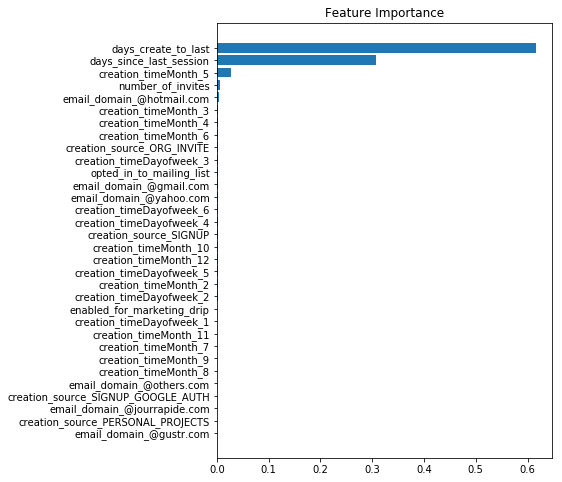

In [496]:
indices = np.argsort(clf_rf_rs_best.feature_importances_)
plt.figure(figsize=[6,8])
plt.barh(col_train[indices], clf_rf_rs_best.feature_importances_[indices])
plt.title('Feature Importance')
plt.show()

### Other Performance Metrics

#### ROC-AUC

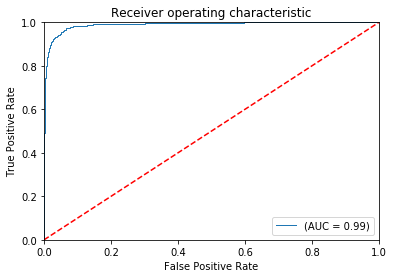

In [497]:
from sklearn.metrics import roc_curve, auc
probas_ = clf_rf_rs_best.predict_proba(df_X_test.values)
fpr, tpr, thresholds = roc_curve(df_y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1.0, label='(AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

#### Precision-Recall Curve

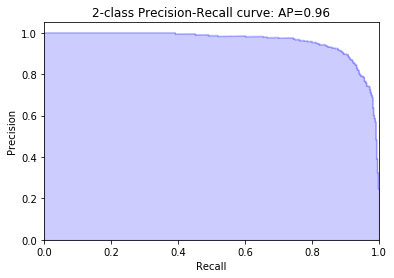

In [500]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
precision, recall, thresholds = precision_recall_curve(df_y_test, probas_[:, 1])
average_precision = average_precision_score(df_y_test, probas_[:, 1])
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


### Discussion

It is noticed that by grid search, the F1-score of RandomForest model for predicting class 1 has been improved from 0.877 to 0.898. Both Precision-Recall curve and ROC-AUC curve suggest the model performance is satisfactory. 

The feature importance agree very well with the observations from correlation analysis (refer to section 3.4 EDA - Correlation Analysis). 

The age (represented by `days_creat_to_last`) and recency (`days_since_last_session`) of users are found to be strong indicators for identifying 'adopted users'. The feature `number_of_invites` ranks the 4th in feature importance, as it has shown close correlation with the top two features (as visualized in Pair Plots in section 3.4 EDA - Correlation Analysis = Pair Plots). 

Besides, feature `creation_timeMonth_5` (representing users joined in June) is also found of high importance. It might be workth to explore if there was any historical events in June that will affect the engagement of users. 

**END**